**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1a) Load the dataset and implement the K Means algorithm. You need to find the optimal number of clusters using the
> i) elbow method

> ii) silhoette method



1b) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

1c) Experiment with different distance measures [Euclidean distance, Manhattan distance].

1d) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.


1e) Visualize the dataset to depict the clusters formed. (prefer T-SNE)

</br>
</br>
</br>
</br>


**Part 2:**
</br>
In this task, you need to implement Hierarchical clustering (agglomerative) on the same dataset.

2a) visualize a dendogram and find out the optimal number of clusters with the help of Dendogram. Explain the procedure.


2b) Implement Hierarchical clustering using: </br>
> i) single linkage

> ii) Complete linkage

>Visualize the clusters obtained using these linkages and compare. 



In [12]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm_notebook
import tensorflow as tf
from sklearn.manifold import TSNE

In [3]:
def compute_point_dist(X):
    return [np.sqrt(np.sum((X - X[i])**2, axis=1)) for i in range(X.shape[0])]

In [17]:
#implement elbow method from scratch
def elbow(distances, n_iters = 10, datapoints = 100, k_max=3, init_method="forgy", dist_method="euclid"):
    curr_testX = trainX[:datapoints, :]
    curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
    loss_list = []
    for k in range(2, k_max+1):
        kmeans = Kmeans(curr_testX.shape, k=k, n_iters=n_iters, dist_method=dist_method, distances = distances)
        if init_method == "forgy":
            kmeans.forgy_init(curr_testX)
        else:
            kmeans.random_init(curr_testX)
        kmeans.fit(curr_testX)
        loss_list.append(kmeans.loss(curr_testX))
    return loss_list

In [19]:
#implement silhouette method from scratch
def silhouette(distances, n_iters = 10, datapoints = 100, k_max=3, init_method="forgy", dist_method="euclid"):
    curr_testX = trainX[:datapoints, :]
    curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
    distances = compute_point_dist(curr_testX)
    score_list = []
    for k in range(2, k_max+1):
        kmeans = Kmeans(curr_testX.shape, k=k, n_iters=n_iters, dist_method=dist_method, distances = distances)
        if init_method == "forgy":
            kmeans.forgy_init(curr_testX)
        else:
            kmeans.random_init(curr_testX)
        kmeans.fit(curr_testX)
        score_list.append(kmeans.silhouette_score(curr_testX))
    return score_list


In [39]:
#implement Kmeans from scratch
class Kmeans:

    def __init__(self, feature_shape, distances, k=3, n_iters = 100, init_method="forgy", dist_method="euclid"):
        self.K = k
        self.init_method = init_method
        self.dist_method = dist_method
        self.m = feature_shape[0]
        self.r = feature_shape[1]
        self.n_iters = n_iters
        self.centroids = np.array([]).reshape((self.r, 0))
        self.dist = np.array([]).reshape((self.m ,0))
        self.minimum_index = np.array([]).reshape((self.m ,0))
        self.sample_dist = distances
            
    def silhouette_score(self, X):
        cluster_count = Counter(self.minimum_index)
        one = np.ones((self.m))
        a = np.array([(np.sum(self.sample_dist[i][self.minimum_index == c])/(cluster_count[c]-1)) if cluster_count[c] > 1 else 0 for i, c in enumerate(self.minimum_index)])
        b = np.array([np.min([(np.mean(self.sample_dist[i][self.minimum_index == k]) if k in cluster_count else np.inf) for k in range(self.K) if k != c] ) for i, c in enumerate(self.minimum_index)])
        score = np.mean((b - a) / np.maximum(np.maximum(b, a), one))
        return score
        
    def loss(self, X):
        loss = 0
        for sample in range(self.m):
            loss += self.dist[sample, self.minimum_index[sample]]
        return loss

    def forgy_init(self, X):
        chosen_points = random.sample(range(0, self.m-1), self.K)
        for index in chosen_points:
            self.centroids = np.c_[self.centroids, X[index]]

    def random_init(self, X):
        random_index = [random.randint(0, self.K-1) for _ in range(self.m)]
        cent = {}
        for k in range(self.K):
            cent[k]=np.array([]).reshape((self.r, 0))
        for sample in range(self.m):
            cent[random_index[sample]] = np.c_[cent[random_index[sample]], X[sample]]
        for k in range(self.K):
            if cent[k].shape[1] != 0:
                self.centroids = np.c_[self.centroids, np.mean(cent[k], axis=1)]
            else:
                self.centroids = np.c_[self.centroids, X[random.randint(0, self.m-1)]]

      
    def euclid(self, X):
        self.dist = np.array([]).reshape((self.m ,0))
        for k in range(self.K):
            dist = np.sum((X-self.centroids[:, k])**2, axis=1)
            self.dist = np.c_[self.dist, dist]
        self.minimum_index = np.argmin(self.dist, axis=1)
        
    def manhattan(self, X):
        self.dist = np.array([]).reshape((self.m ,0))
        for k in range(self.K):
            dist = np.sum(np.absolute(X-self.centroids[:, k]), axis=1)
            self.dist = np.c_[self.dist, dist]
        self.minimum_index = np.argmin(self.dist, axis=1)

    def fit(self, X):
        for iter in range(self.n_iters):
            if self.dist_method == "euclid":
                self.euclid(X)
            elif self.dist_method == "manhattan":
                self.manhattan(X)
            self.centroids = np.array([np.mean(X[self.minimum_index == c], axis=0) if len(X[self.minimum_index == c]) != 0 else self.centroids[:, c].T for c in range(self.K)]).T


  

In [13]:
(trainX, trainy), (testX, testy) = tf.keras.datasets.fashion_mnist.load_data()

# you can performs your training on train/test dataset alone if there are computational issues

In [43]:
k_max = 10
datapoints = 10000

In [25]:
curr_testX = trainX[:datapoints, :]
curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
distances = compute_point_dist(curr_testX)

### Running Clustering by varying all the parameters (initialization, distance & loss score method)

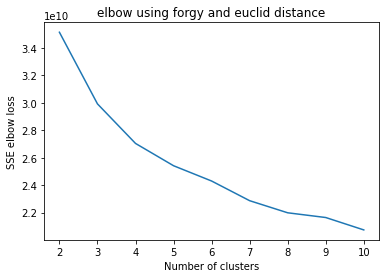

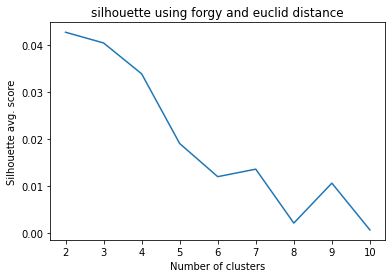

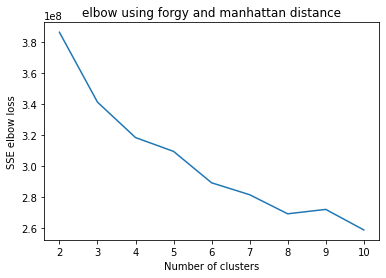

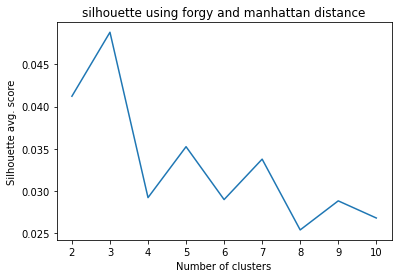

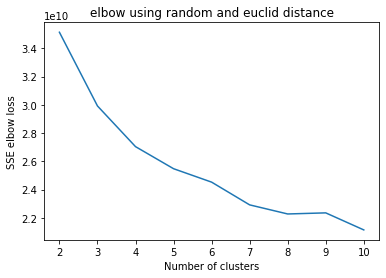

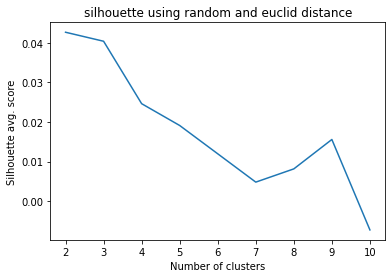

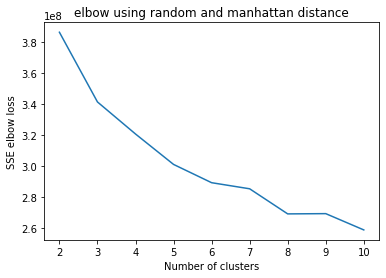

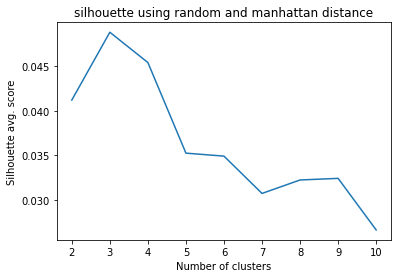

In [44]:
for init in ["forgy", "random"]:
    for dist in ["euclid", "manhattan"]:
        for score in ["elbow", "silhouette"]:
            if score == "elbow":
                loss_list = elbow(n_iters=50, datapoints=datapoints, k_max=k_max, dist_method=dist, init_method=init, distances=distances)
                sns.lineplot(x=np.arange(2, k_max+1), y=loss_list)
                plt.ylabel('SSE elbow loss')
            else:
                score_list = silhouette(n_iters=50, datapoints=datapoints, k_max=k_max, dist_method=dist, init_method=init, distances=distances)
                sns.lineplot(x=np.arange(2, k_max+1), y=score_list)
                plt.ylabel('Silhouette avg. score')
            plt.title(f'{score} using {init} and {dist} distance')
            plt.xlabel('Number of clusters')
            plt.show()

From the above plots, we observe that the elbow formation is generally happening at K=3. Similarly, the silhouette score is also at the peak positive for cluster 3. Therefore, the optimal number of clusters (on an average) comes out to be 3.

## T-SNE Visualization

In [19]:
def visualize(tsne, labels, K):
    plot_data = {"x": tsne[:, 0], "y": tsne[:, 1], "cluster": labels}
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="cluster",
        palette=sns.color_palette("hls", K),
        data=plot_data,
        legend="full",
    )

def kmeans_tsne(distances, datapoints=100, n_iters=40, n_components=5):
    curr_testX = trainX[:datapoints, :]
    curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
    kmeans = Kmeans(curr_testX.shape, k=n_components, n_iters=50, dist_method="euclid", init_method="random", distances=distances)
    kmeans.random_init(curr_testX)
    kmeans.fit(curr_testX)
    return kmeans

def get_tsne(datapoints=100, n_components=2):
    curr_testX = trainX[:datapoints, :]
    curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
    data = np.reshape(curr_testX, (curr_testX.shape[0], -1))
    tsne = TSNE(n_components=n_components, perplexity=40, n_iter=300, learning_rate='auto', init='random').fit_transform(data)
    return tsne

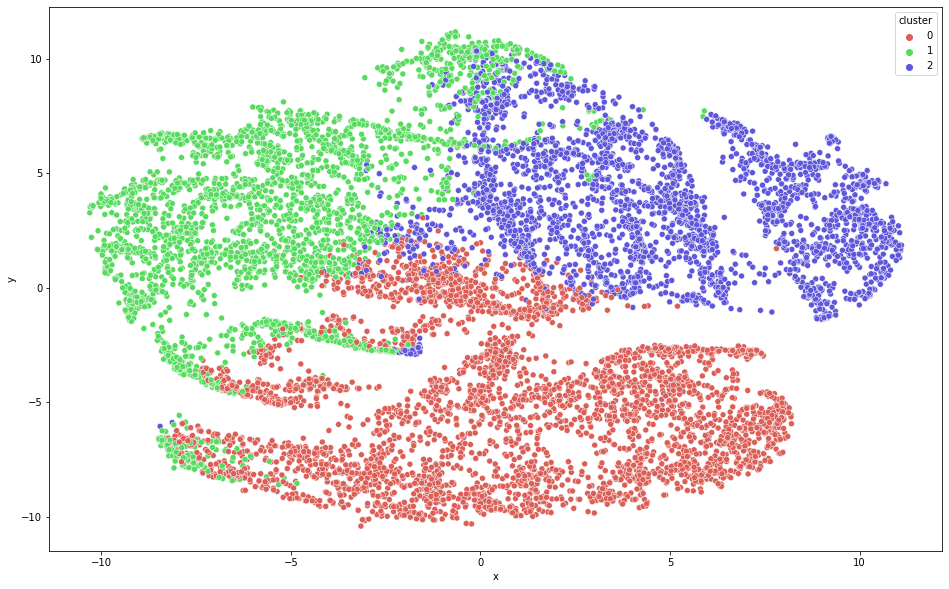

In [94]:
kmeans_value = kmeans_tsne(distances, datapoints=10000, n_components=3)
tsne = get_tsne(datapoints=10000, n_components=2)
visualize(tsne, kmeans_value.minimum_index, kmeans_value.K)

## Agglomerative clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

Hierarchical clustering

In [15]:
# implement hierarchical clustering ( you can use scikit module)

def hierarchical_clustering(datapoints=1000, n_clusters=5, affinity='euclidean', linkage='complete'):
    curr_testX = trainX[:1000, :]
    curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage).fit(curr_testX)
    return clustering.labels_



In [24]:
#visualize a dendogram

def dendogram(X, method='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))

  

### Dendogram

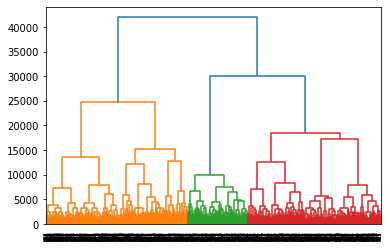

In [6]:
curr_testX = trainX[:1000, :]
curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
dendogram(curr_testX)

**Question**: Explain the procedure to find the optimal number of clusters using dendogram

Answer: </br>
We first extend all the horizontal lines from left to right. </br> 
Next we find the largest vertical line between two consecutive horizontal lines, i.e. maximum loss incurred in reaching the next iteration for clustering. </br>
After finding these two horizontal lines we make another horizontal line equi-distant from both the selected horizontal lines</br>
The number of times the created horizontal line cuts the dendogram's vertical lines is the number of optimal clusters.</br>
Here we find that the optimal number of clusters come out to be 2.</br>





### Aglomeratic clustering with single linkage

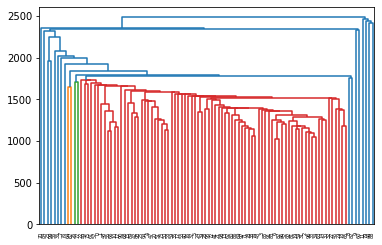

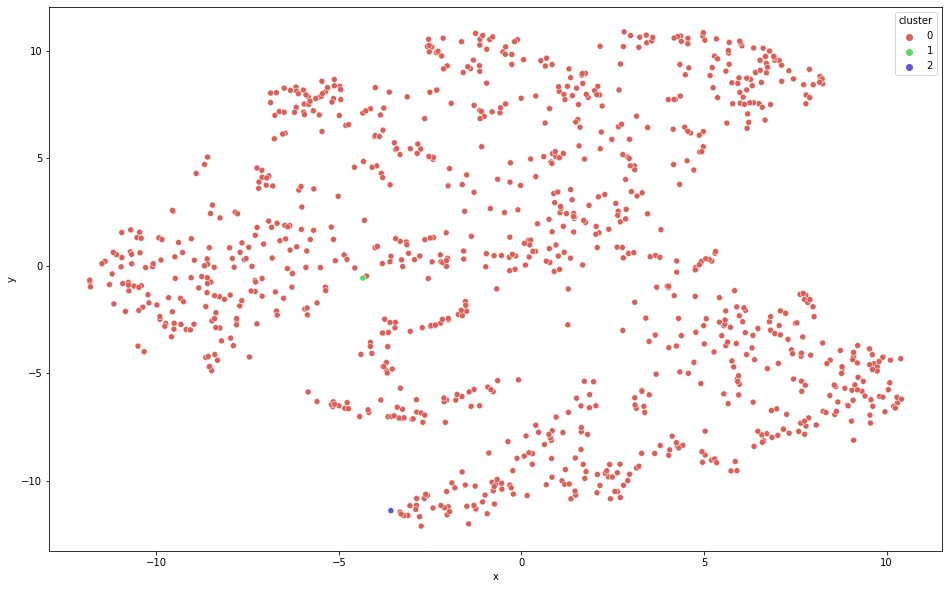

In [27]:
#visualisation of clusters using single linkage and complete linkage
clusters = 3
curr_testX = trainX[:100, :]
curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
label = hierarchical_clustering(datapoints=100, n_clusters=clusters, affinity='euclidean', linkage='single')
dendogram(curr_testX, method='single')
tsne = get_tsne(datapoints=1000, n_components=2)
visualize(tsne, label, clusters)

### Aglomeratic clustering with complete linkage

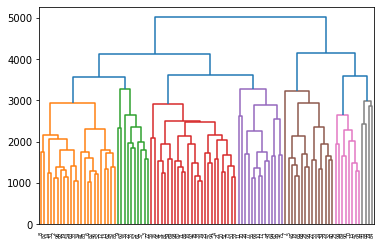

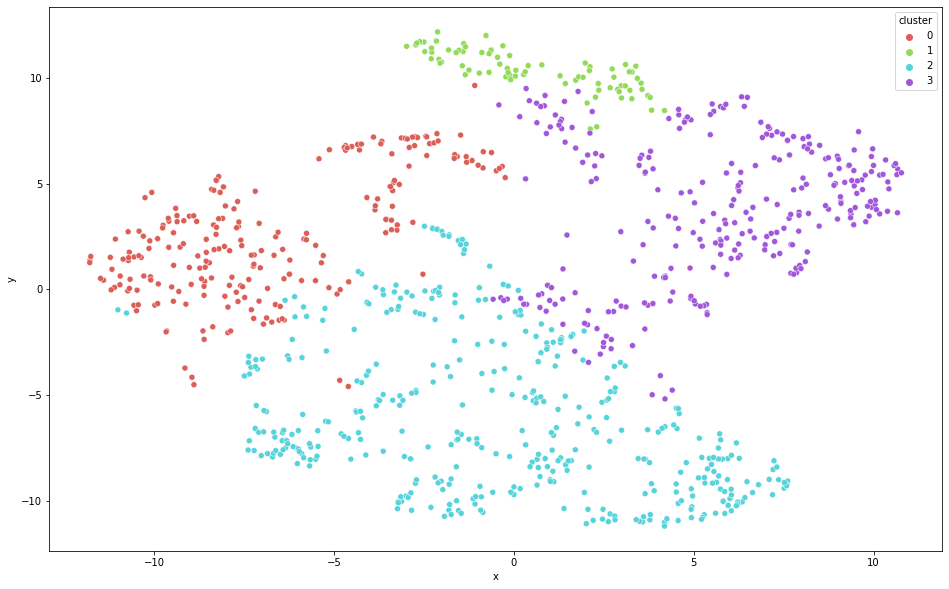

In [31]:
clusters = 4
curr_testX = trainX[:100, :]
curr_testX = curr_testX.reshape(curr_testX.shape[0], curr_testX.shape[1]*curr_testX.shape[2])
label = hierarchical_clustering(datapoints=100, n_clusters=clusters, affinity='euclidean', linkage='complete')
tsne = get_tsne(datapoints=1000, n_components=2)
dendogram(curr_testX, method='complete')
visualize(tsne, label, clusters)

**Question:** Mention the differences observed using single and complete linkage:

Answer: </br>
We observe that for single linkage class all the datapoints are considered in a single cluster. Even the dendrogram suggests that the number of clusters should be 1. This might be possible because the datapoint are spread out and the closest datapoints between two clusters become very small. Due to this we consider both the datapoints in the same cluster.
</br></br>
We observe that in complete linkage class we have four distinct clusters with a well defined shape. We can also observed that the dendogram suggest 4 clusters as optimal. This can be attributed to the fact that clusters are formed considering the datapoints with have the maximum dissimilarity, thereby making joining more spread out clusters difficult.
